## 1. Imports and Configuration

In [1]:
import sys
from pathlib import Path
from datetime import datetime, timedelta

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from loguru import logger

# Add root directory to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Import synchronous MET Norway adapter
from scripts.api.services.met_norway.met_norway_sync_adapter import METNorwaySyncAdapter

# Configure logging
logger.remove()
logger.add(sys.stdout, level="INFO")

# Configure plot style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Imports completed")

Imports completed


## 2. Initialize MET Norway Client

In [2]:
# Create synchronous adapter (no cache for demo)
met_adapter = METNorwaySyncAdapter()

# Check API information
info = met_adapter.get_coverage_info()
print("\nMET Norway API Information:")
for key, value in info.items():
    print(f"  {key}: {value}")

2025-11-28 14:12:07.717 | INFO     | scripts.api.services.met_norway.met_norway_sync_adapter:__init__:55 - METNorwaySyncAdapter initialized (GLOBAL)

MET Norway API Information:
  adapter: METNorwaySyncAdapter
  coverage: GLOBAL with regional quality optimization
  bbox: {'lon_min': -180, 'lat_min': -90, 'lon_max': 180, 'lat_max': 90}
  quality_tiers: {'nordic': {'region': 'Norway, Denmark, Sweden, Finland, Baltics', 'bbox': (4.0, 54.0, 31.0, 71.5), 'resolution': '1 km', 'model': 'MEPS 2.5km + MET Nordic downscaling', 'updates': 'Hourly', 'post_processing': 'Extensive (radar + Netatmo crowdsourced)', 'variables': ['air_temperature_max', 'air_temperature_min', 'air_temperature_mean', 'relative_humidity_mean', 'precipitation_sum'], 'precipitation_quality': 'Very High (radar + bias correction)'}, 'brazil': {'region': 'Brazil', 'bbox': (-74.0, -34.0, -34.0, 5.0), 'resolution': '11 km (Open-Meteo fallback recommended)', 'model': 'ECMWF IFS', 'updates': '4x per day', 'variables': ['air_tempe

## 3. Example 1: Nordic Region Data - Oslo, Norway

Nordic Region has **complete coverage** including precipitation (1km MET Nordic).

**Coordinates**: 59.9139°N, 10.7522°E  
**Period**: Last 5 days

In [3]:
# Define location: Oslo, Norway
lat_oslo = 59.9139
lon_oslo = 10.7522
location_oslo = "Oslo, Norway (Nordic Region)"

start_date = datetime.now()
end_date = start_date + timedelta(days=5)

print(f"Location: {location_oslo}")
print(f"Period: {start_date.date()} to {end_date.date()}")
print(f"Coordinates: {lat_oslo:.4f}°, {lon_oslo:.4f}°")
print(f"Nordic Region: Temp + Humidity + Precipitation (1km MET Nordic)")

Location: Oslo, Norway (Nordic Region)
Period: 2025-11-28 to 2025-12-03
Coordinates: 59.9139°, 10.7522°
Nordic Region: Temp + Humidity + Precipitation (1km MET Nordic)


In [4]:
%pip install nest_asyncio
import nest_asyncio
nest_asyncio.apply()

# Download Oslo data
print("\nDownloading data from MET Norway (Nordic Region)...\n")

oslo_data = met_adapter.get_daily_data_sync(
    lat=lat_oslo,
    lon=lon_oslo,
    start_date=start_date,
    end_date=end_date
)

print(f"\nData downloaded: {len(oslo_data)} records")


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


2025-11-28 14:12:14.274 | INFO     | scripts.api.services.met_norway.met_norway_sync_adapter:_async_get_daily_data:187 - Querying MET Norway API: (59.9139, 10.7522, Nonem) - NORDIC (1km + radar)
2025-11-28 14:12:14.275 | INFO     | scripts.api.services.met_norway.met_norway_client:get_daily_forecast:402 - MET Norway (NORDIC (1km)): lat=59.9139, lon=10.7522, altitude=Nonem, variables=5
2025-11-28 14:12:14.276 | INFO     | scripts.api.services.met_norway.met_norway_client:get_daily_forecast:450 - Querying MET Norway API...
2025-11-28 14:12:14.274 | INFO     | scripts.api.services.met_norway.met_norway_sync_adapter:_async_get_daily_data:187 - Querying MET Norway API: (59.9139, 10.7522, Nonem) - NORDIC (1km + radar)
2025-11-28 14:12:14.275 | INFO     | scripts.api.services.met_norway.met_norway_client:get_daily_forecast:402 - MET Norway (NORDIC (1km)): lat=59.9139, lon=10.7522, altitude=Nonem, variables=5
2025-11-28 14:12:

In [5]:
# Convert to DataFrame
df_oslo = pd.DataFrame([
    {
        'date': record['date'],
        'temp_max': record['temp_max'],
        'temp_min': record['temp_min'],
        'temp_mean': record['temp_mean'],
        'humidity_mean': record['humidity_mean'],
        'wind_speed_2m_mean': record['wind_speed_2m_mean'],
        'precipitation_sum': record['precipitation_sum']
    }
    for record in oslo_data
])

# Display data
print("\nOslo Data (Nordic Region):")
display(df_oslo)
print(f"\nPrecipitation available: {df_oslo['precipitation_sum'].notna().sum()} records")


Oslo Data (Nordic Region):


,date,temp_max,temp_min,temp_mean,humidity_mean,wind_speed_2m_mean,precipitation_sum
0,2025-11-28,9.0,7.4,8.533333,85.933333,6.150222,4.200000
1,2025-11-29,7.9,1.3,5.758333,82.841667,2.814350,1.800000
2,2025-11-30,3.0,1.6,2.236842,82.247368,4.338400,12.300000
3,2025-12-01,4.9,-0.5,2.000000,90.175000,1.888700,1.550000
4,2025-12-02,6.3,4.3,5.675000,96.625000,3.571700,3.075000
5,2025-12-03,6.3,5.0,5.866667,97.700000,1.720400,0.766667



Precipitation available: 6 records


### Visualize Oslo Data (with Precipitation)

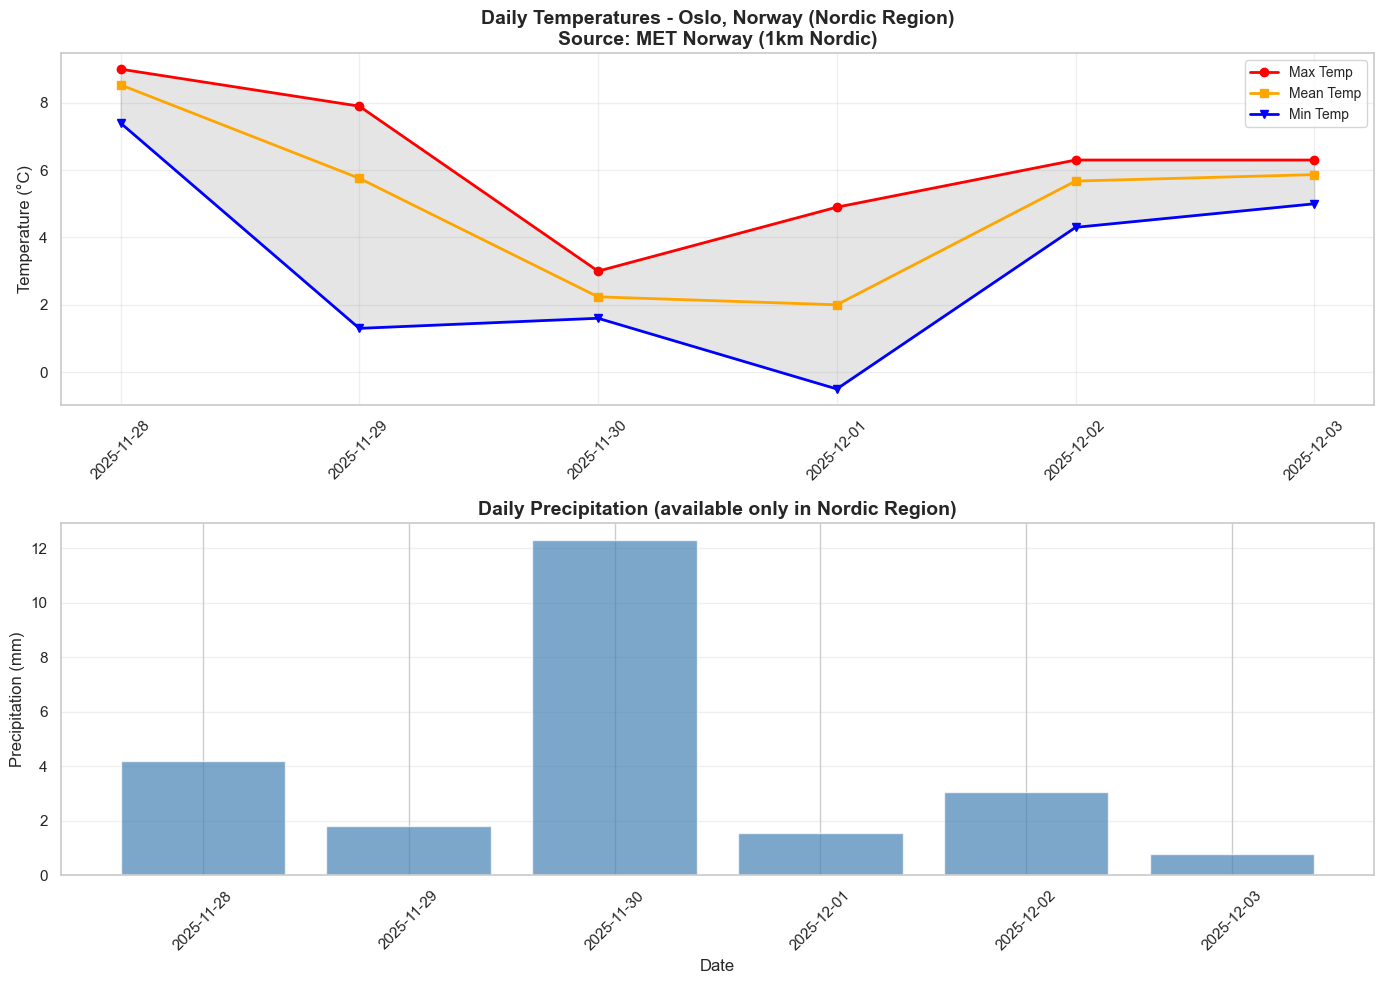

In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Temperatures
ax1.plot(df_oslo['date'], df_oslo['temp_max'], label='Max Temp', color='red', linewidth=2, marker='o')
ax1.plot(df_oslo['date'], df_oslo['temp_mean'], label='Mean Temp', color='orange', linewidth=2, marker='s')
ax1.plot(df_oslo['date'], df_oslo['temp_min'], label='Min Temp', color='blue', linewidth=2, marker='v')
ax1.fill_between(df_oslo['date'], df_oslo['temp_min'], df_oslo['temp_max'], alpha=0.2, color='gray')
ax1.set_ylabel('Temperature (°C)', fontsize=12)
ax1.set_title(f'Daily Temperatures - {location_oslo}\nSource: MET Norway (1km Nordic)', 
              fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Precipitation
ax2.bar(df_oslo['date'], df_oslo['precipitation_sum'], color='steelblue', alpha=0.7)
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Precipitation (mm)', fontsize=12)
ax2.set_title('Daily Precipitation (available only in Nordic Region)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
plt.tight_layout()
plt.show()

## 4. Example 2: Global Data - Rio de Janeiro, Brazil

Outside Nordic Region: **Temp + Humidity only** (9km ECMWF, no precipitation).

**Coordinates**: -22.9068°S, -43.1729°W  
**Period**: Last 5 days

In [7]:
# Define location: Rio de Janeiro, Brazil
lat_rio = -22.9068
lon_rio = -43.1729
location_rio = "Rio de Janeiro, Brazil (Global Coverage)"

print(f"Location: {location_rio}")
print(f"Period: {start_date.date()} to {end_date.date()}")
print(f"Coordinates: {lat_rio:.4f}°, {lon_rio:.4f}°")
print(f"Rest of World: Temp + Humidity only (9km ECMWF, skip precipitation)")

Location: Rio de Janeiro, Brazil (Global Coverage)
Period: 2025-11-28 to 2025-12-03
Coordinates: -22.9068°, -43.1729°
Rest of World: Temp + Humidity only (9km ECMWF, skip precipitation)


In [8]:
# Download Rio de Janeiro data
print("\nDownloading data from MET Norway (Global Coverage)...\n")

rio_data = met_adapter.get_daily_data_sync(
    lat=lat_rio,
    lon=lon_rio,
    start_date=start_date,
    end_date=end_date
)

print(f"\nData downloaded: {len(rio_data)} records")



2025-11-28 14:12:15.327 | INFO     | scripts.api.services.met_norway.met_norway_sync_adapter:_async_get_daily_data:187 - Querying MET Norway API: (-22.9068, -43.1729, Nonem) - BRAZIL (Xavier et al. validation)
2025-11-28 14:12:15.328 | INFO     | scripts.api.services.met_norway.met_norway_client:get_daily_forecast:402 - MET Norway (GLOBAL (9km)): lat=-22.9068, lon=-43.1729, altitude=Nonem, variables=4
2025-11-28 14:12:15.329 | INFO     | scripts.api.services.met_norway.met_norway_client:get_daily_forecast:450 - Querying MET Norway API...
2025-11-28 14:12:15.328 | INFO     | scripts.api.services.met_norway.met_norway_client:get_daily_forecast:402 - MET Norway (GLOBAL (9km)): lat=-22.9068, lon=-43.1729, altitude=Nonem, variables=4
2025-11-28 14:12:15.329 | INFO     | scripts.api.services.met_norway.met_norway_client:get_daily_forecast:450 - Querying MET Norway API...
2025-11-28 14:12:15.568 | INFO     | scripts.api.services.met_norway.met_norway_client:_log_fetch_summary:711 - MET Norw

In [9]:
# Convert to DataFrame
df_rio = pd.DataFrame([
    {
        'date': record['date'],
        'temp_max': record['temp_max'],
        'temp_min': record['temp_min'],
        'temp_mean': record['temp_mean'],
        'humidity_mean': record['humidity_mean'],
    }
    for record in rio_data
])

# Display data
print("\nRio de Janeiro Data (Global Coverage):")
display(df_rio)
print(f"\nPrecipitation not available (use Open-Meteo for precipitation outside Nordic Region)")


Rio de Janeiro Data (Global Coverage):


,date,temp_max,temp_min,temp_mean,humidity_mean
0,2025-11-28,28.6,21.2,26.044444,74.600000
1,2025-11-29,29.8,20.7,24.491667,83.129167
2,2025-11-30,31.4,20.6,24.775000,80.758333
3,2025-12-01,30.0,20.6,23.311111,88.755556
4,2025-12-02,33.3,22.4,27.800000,73.200000
5,2025-12-03,26.6,23.3,25.800000,87.066667



Precipitation not available (use Open-Meteo for precipitation outside Nordic Region)


### Visualize Rio Data (without Precipitation)

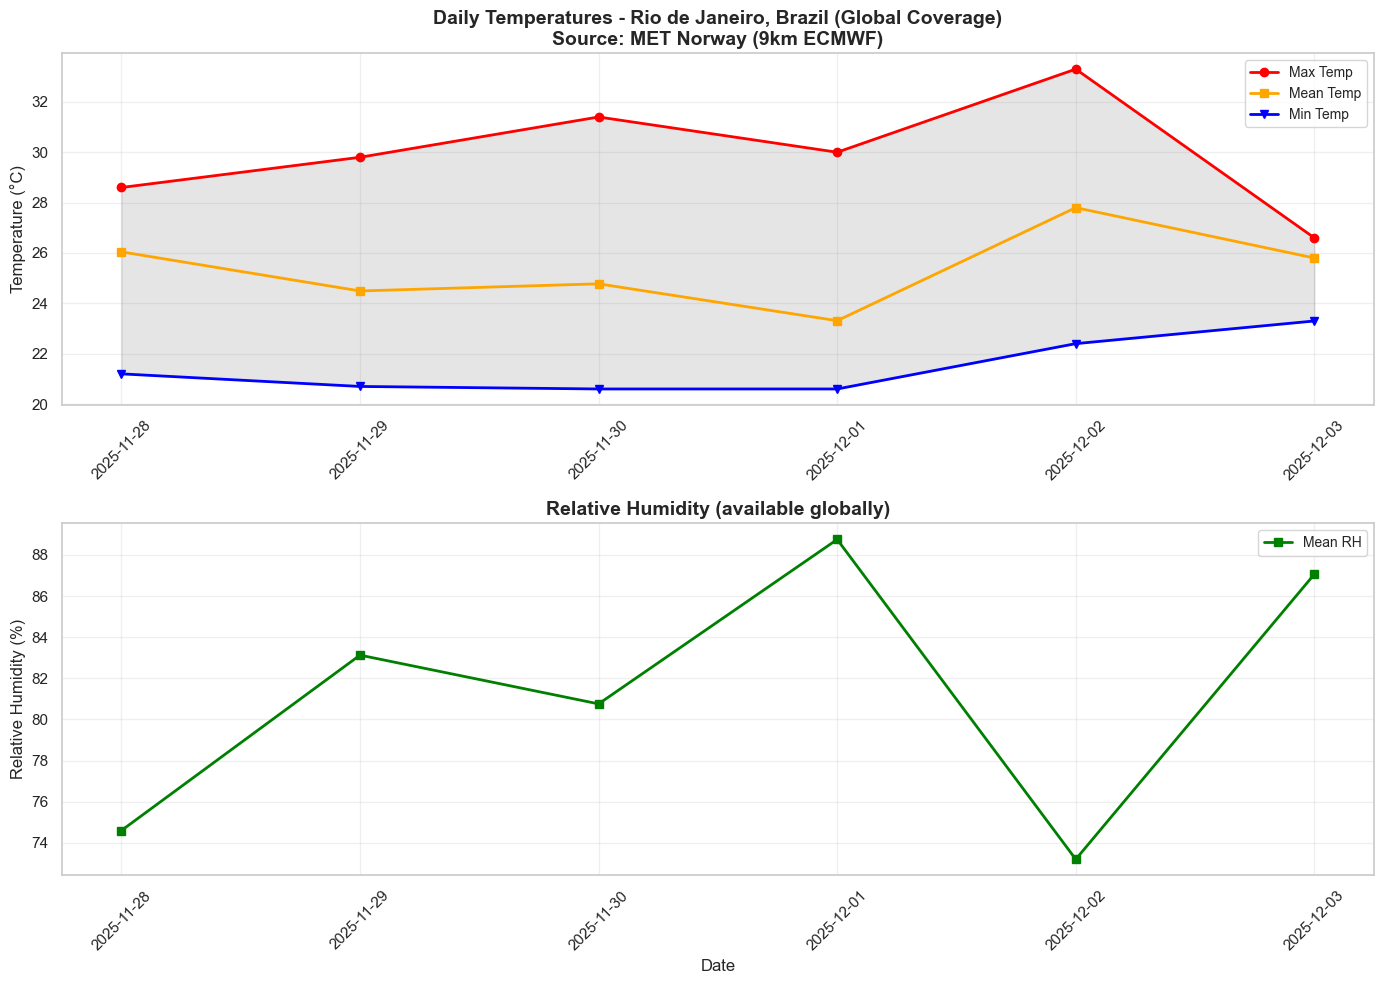

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Temperatures
ax1.plot(df_rio['date'], df_rio['temp_max'], label='Max Temp', color='red', linewidth=2, marker='o')
ax1.plot(df_rio['date'], df_rio['temp_mean'], label='Mean Temp', color='orange', linewidth=2, marker='s')
ax1.plot(df_rio['date'], df_rio['temp_min'], label='Min Temp', color='blue', linewidth=2, marker='v')
ax1.fill_between(df_rio['date'], df_rio['temp_min'], df_rio['temp_max'], alpha=0.2, color='gray')
ax1.set_ylabel('Temperature (°C)', fontsize=12)
ax1.set_title(f'Daily Temperatures - {location_rio}\nSource: MET Norway (9km ECMWF)', 
              fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Relative Humidity (only mean available)
ax2.plot(df_rio['date'], df_rio['humidity_mean'], label='Mean RH', color='green', linewidth=2, marker='s')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Relative Humidity (%)', fontsize=12)
ax2.set_title('Relative Humidity (available globally)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
plt.tight_layout()
plt.show()

## 5. Comparison: Nordic vs Global Coverage

In [11]:
print("\nComparison: Nordic Region vs Global Coverage")
print("=" * 70)
print(f"\n{'Location':<30} {'Region':<15} {'Precipitation'}")
print("-" * 70)
print(f"{location_oslo:<30} {'Nordic':<15} {'Available (1km MET Nordic)'}")
print(f"{location_rio:<30} {'Global':<15} {'Not available (9km ECMWF)'}")
print("\nNote: Use Open-Meteo for precipitation outside Nordic Region")


Comparison: Nordic Region vs Global Coverage

Location                       Region          Precipitation
----------------------------------------------------------------------
Oslo, Norway (Nordic Region)   Nordic          Available (1km MET Nordic)
Rio de Janeiro, Brazil (Global Coverage) Global          Not available (9km ECMWF)

Note: Use Open-Meteo for precipitation outside Nordic Region


## 6. Health Check

In [12]:
# Check API availability
is_healthy = met_adapter.health_check_sync()

if is_healthy:
    print("MET Norway API is working correctly")
else:
    print("MET Norway API is not accessible")

2025-11-28 14:12:16.150 | INFO     | scripts.api.services.met_norway.met_norway_client:health_check:746 - MET Norway health check: OK
2025-11-28 14:12:16.151 | INFO     | scripts.api.services.met_norway.met_norway_sync_adapter:_async_health_check:246 - MET Norway health check: OK (GLOBAL)
MET Norway API is working correctly
2025-11-28 14:12:16.151 | INFO     | scripts.api.services.met_norway.met_norway_sync_adapter:_async_health_check:246 - MET Norway health check: OK (GLOBAL)
MET Norway API is working correctly


## 7. Save Data

In [13]:
# Save Oslo data
output_oslo = project_root / "data" / "csv" / "met_norway_oslo_demo.csv"
output_oslo.parent.mkdir(parents=True, exist_ok=True)
df_oslo.to_csv(output_oslo, index=False)
print(f"\nOslo data saved to: {output_oslo}")

# Save Rio data
output_rio = project_root / "data" / "csv" / "met_norway_rio_demo.csv"
df_rio.to_csv(output_rio, index=False)
print(f"Rio data saved to: {output_rio}")


Oslo data saved to: c:\Users\User\OneDrive\Documentos\GitHub\EVAONLINE\EVAonline_validation_v1.0.0\data\csv\met_norway_oslo_demo.csv
Rio data saved to: c:\Users\User\OneDrive\Documentos\GitHub\EVAONLINE\EVAonline_validation_v1.0.0\data\csv\met_norway_rio_demo.csv


---

## References

**MET Norway (Norwegian Meteorological Institute)**
- Website: https://www.met.no/
- API Documentation: https://api.met.no/weatherapi/locationforecast/2.0/documentation
- Citation: MET Norway - Norwegian Meteorological Institute

**License**: Norwegian Licence for Open Government Data (NLOD) 2.0 and Creative Commons 4.0 BY International 

**Regional Strategy**:
- **Nordic Region** (NO/SE/FI/DK/Baltics): 1km MET Nordic with precipitation (radar + crowdsourced bias correction)
- **Rest of World**: 9km ECMWF with temp + humidity (no precipitation)

---